# TP1 : First order methods on regression models

#### Authors: S. Gaiffas, A. Gramfort

## Aim

The aim of this material is to code 
- proximal gradient descent (ISTA)
- accelerated gradient descent (FISTA) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- ridge penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 9th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 3 octobre 2016**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "peter"
ln1 = "martigny"
fn2 = "benoît"
ln2 = "choffin"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp1_martigny_peter_and_choffin_benoît.ipynb


In [2]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn


#np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

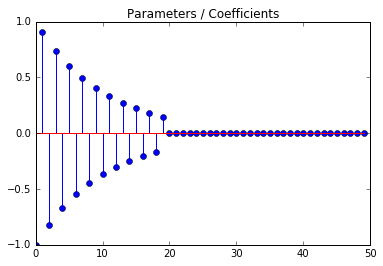

In [4]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = (-1) ** (idx - 1) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [5]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

def sigmoid(t):
    """Sigmoid function (overflow-proof)"""
    idx = t > 0
    out = np.empty(t.size)
    out[idx] = 1. / (1 + np.exp(-t[idx]))
    exp_t = np.exp(t[~idx])
    out[~idx] = exp_t / (1. + exp_t)
    return out

def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b[:] = 2 * b - 1
    return A, b

In [6]:
sigmoid(np.array([1, 2, 10, -np.log(2)]))

array([ 0.73105858,  0.88079708,  0.9999546 ,  0.33333333])

## Part 1 : Proximal operators

We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(y, t) = \arg\min_x \Big\{ \frac 12 \|x - y\|_2^2 + t g(x) \Big\}.
$$

where $t \geq 0$ is a non-negative number.
We have in mind to use the following cases

- Ridge penalization, where $g(x) = \frac{s}{2} \|x\|_2^2$
- Lasso penalization, where $g(x) = s \|x\|_1$

where $s \geq 0$ is a regularization parameter.

## Questions

- Code a function that computes $g(x)$ in both cases and $\text{prox}_g(x)$ for ridge and  lasso penalization (use the slides of the first course to get the formulas), using the prototypes given below
- Visualize the functions applied element wise by the proximity operators of the Ridge and Lasso 

In [63]:
def prox_lasso(x, s, t=1.):
    """Proximal operator for the Lasso at x with strength t"""   
    aux = np.abs(x)
    result = np.sign(x) * np.maximum((aux - s*t), 0)
    return result # TODO
    
def lasso(x, s):
    """Value of the Lasso penalization at x with strength t"""
    aux = np.abs(x)
    result = s * np.sum(aux)
    return result # TODO

def prox_ridge(x, s, t=1.):
    """Proximal operator for the ridge at x with strength t"""    
    result = (1/(1 + s*t)) * x
    return result # TODO
    
def ridge(x, s):
    """Value of the ridge penalization at x with strength t"""
    result = (s/2) * np.sum(x ** 2)
    return result # TODO

Test functions

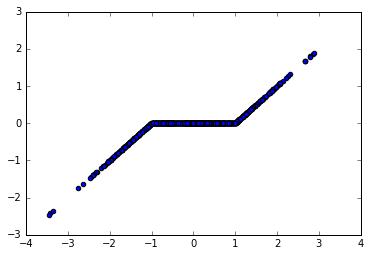

In [66]:
x = randn(1000)
x_bar = prox_lasso(x, 0.5, 2)
plt.scatter(x = x, y = x_bar)

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

[ 0.          0.          0.          0.         -0.          0.         -0.
  0.          0.          0.         -0.          0.         -0.         -0.
 -0.          0.75938739 -0.          0.75021499 -0.56763691 -0.         -0.
 -0.          0.          0.          0.36862734 -0.         -0.         -0.
  0.          0.22083839  0.          0.99936189  0.11958897 -1.77362222
 -0.         -0.          0.         -0.         -0.          0.56635018
 -0.         -0.          0.         -0.58079051 -0.         -0.
  0.04151369  0.         -0.          0.0440285 ]


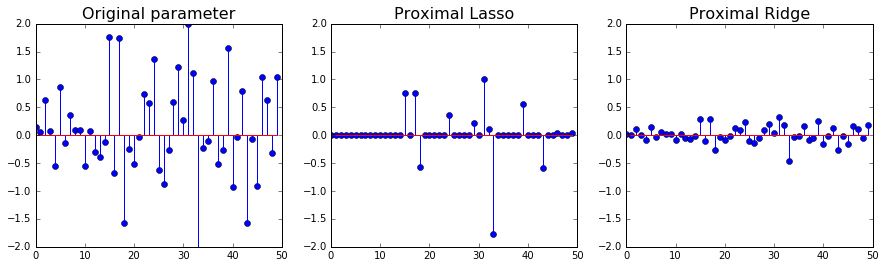

In [67]:
x = randn(50)
l_l1 = 1.
l_l2 = 5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, s=l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_ridge(x, s=l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim([-2, 2])
print(prox_lasso(x, s = l_l1))

## Question

- Comment what you observe (1 or 2 sentences).

We observe that a relatively small lasso parameter has a significant effect on the sparsity of the coefficients, whereas it requires a bigger ridge parameter to have a similar effect. Additionnaly, the lasso shrinks certain coefficients exactly to 0, whereas the ridge only lowers the general magnitude of the coefficients, but they are not null.

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + g(x)
$$
where $f$ is $L$-smooth and $g$ is prox-capable.

We will consider below the following cases

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

**Questions**:
- Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)
- Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.
- Check that these functions are correct by numerically checking the gradient, using the function ``checkgrad`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model

In [71]:
def loss_linreg(x):
    """Least-squares loss"""
    n = n_samples
    result = (1/(2*n)) * (((b - np.dot(A, x)) ** 2).sum())
    # TODO
    return result

def grad_linreg(x):
    """Leas-squares gradient"""
    n = n_samples
    result = (1/n)*np.dot(np.transpose(A), (np.dot(A, x) - b))
    # TODO
    return result

def loss_logreg(x):
    """Logistic loss"""
    n = n_samples
    result = (1/(2*n))*sum(np.log(1 + np.exp(-b[i]*np.dot(np.transpose(A[i, :]), x))) for i in range(n))
    # TODO
    return result

def grad_logreg(x):
    """Logistic gradient"""
    n = n_samples
    result = (1/(2*n))*sum((-b[i]*np.transpose(A[i, :])*np.exp(-b[i]*np.dot(np.transpose(A[i, :]), x)))/(1 + np.exp(-b[i]*np.dot(np.transpose(A[i, :]), x))) for i in range(n))
    # TODO
    return result

# TO BE COMPLETED

In [72]:
from scipy.optimize import check_grad

In [76]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
x = coefs
print('Check the linreg gradient: ', check_grad(loss_linreg, grad_linreg, x))

A, b = simu_logreg(coefs, n_samples=1000, corr=0.5)
x = coefs
print('Check the linlog gradient: ', check_grad(loss_logreg, grad_logreg, x))

Check the linreg gradient:  4.53488332229e-08
Check the linlog gradient:  1.22523296665e-07


## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $g$ and $\text{prox}_g$. 

We want now to code the Ista and Fista solvers to minimize

$$
\arg\min_x f(x) + g(x)
$$

**Questions**:

- Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function `numpy.linalg.norm` (read the documentation
  of the function)

- Finish the functions `ista` and `fista` below that implements the 
  ISTA (Proximal Gradient Descent) and FISTA (Accelerated Proximal 
  Gradient Descent) algorithms

In [77]:
from numpy.linalg import norm

In [78]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
L = lip_linreg(A)
L

3.3339217403721721

In [79]:
def lip_linreg(A):
    """Lipschitz constant for linear squares loss"""  
    n = A[:, 1].size
    result = (1/n) * norm(np.dot(np.transpose(A), A), 2)
    # TODO
    return result
    
def lip_logreg(A):
    """Lipschitz constant for logistic loss"""    
    n = A[:, 1].size
    result = (1/(4*n)) * norm(np.dot(np.transpose(A), A), 2)
    # TODO
    return result
    
def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        
        x = x - step*grad_f(x) #prox_g(x - step*grad_f(x), s, step)
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

Test the ISTA Algorithm

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 8.87e+00 | 2.63e+00
      10 | 1.09e+00 | 7.81e-01
      20 | 5.66e-01 | 2.65e-01
      30 | 5.06e-01 | 1.22e-01
      40 | 4.98e-01 | 1.05e-01
      50 | 4.97e-01 | 1.08e-01
The last error measure is:  0.107780275117


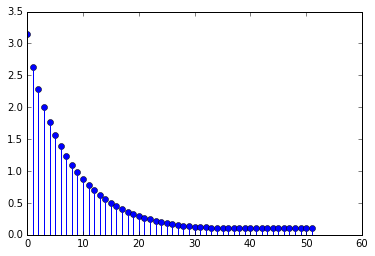

In [141]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
L = lip_linreg(A)

x = randn(50)
Z = ista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0, n_iter =50)
plt.stem(Z[2])
print('The last error measure is: ', Z[2][50])

We observe that the error doesn't converge exactly to zero

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 2.22e+01 | 2.78e+00
      10 | 1.89e+01 | 2.53e+00
      20 | 1.62e+01 | 2.30e+00
      30 | 1.40e+01 | 2.10e+00
      40 | 1.22e+01 | 1.91e+00
      50 | 1.07e+01 | 1.74e+00
      60 | 9.45e+00 | 1.58e+00
      70 | 8.46e+00 | 1.44e+00
      80 | 7.65e+00 | 1.31e+00
      90 | 6.99e+00 | 1.20e+00
     100 | 6.46e+00 | 1.10e+00
     110 | 6.02e+00 | 1.00e+00
     120 | 5.66e+00 | 9.22e-01
     130 | 5.36e+00 | 8.49e-01
     140 | 5.11e+00 | 7.84e-01
     150 | 4.91e+00 | 7.26e-01
     160 | 4.74e+00 | 6.74e-01
     170 | 4.60e+00 | 6.29e-01
     180 | 4.48e+00 | 5.88e-01
     190 | 4.37e+00 | 5.52e-01
     200 | 4.29e+00 | 5.20e-01
     210 | 4.21e+00 | 4.92e-01
     220 | 4.15e+00 | 4.67e-01
     230 | 4.10e+00 | 4.46e-01
     240 | 4.05e+00 | 4.27e-01
     250 | 4.01e+00 | 4.10e-01
     260 | 3.98e+00 | 3.96e-01
     270 | 3.94e+00 | 3.83e-01
     280 | 3.92e+00 | 3.73e-01
     290 | 3.89e+00 | 3.63e-01
     300 | 3.87

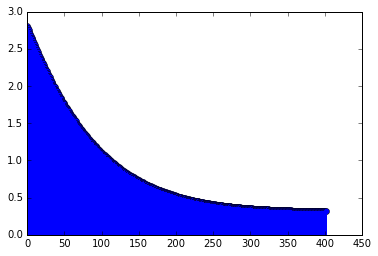

In [132]:
A, b = simu_logreg(coefs, n_samples=1000, corr=0.5)
L = lip_linreg(A)

x = randn(50)
Z = ista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=1, n_iter =400)
plt.stem(Z[2])
print('The last error measure is: ', Z[2][400])

For logistic regression, we observe that the convergence is not as fast as with linear regression

In [149]:
def fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()   
    
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    
    t = 1.
    t_new = 1.
    
#     if verbose:
#         print("Lauching FISTA solver...")
#         print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        
        x_new = prox_g(z - step*grad_f(z), s, step)
        t_new = (1/2)*(1 + np.sqrt(1 + 4*(t**2)))
        z_new = x_new + ((t-1)/t_new)*(x_new - x)
        
        x = x_new
        t = t_new
        z = z_new
        
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
#         if k % 10 == 0 and verbose:
#             print(' | '.join([("%d" % k).rjust(8), 
#                               ("%.2e" % obj).rjust(8), 
#                               ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.20e+01 | 2.90e+00
      10 | 1.06e+00 | 8.39e-01
      20 | 5.27e-01 | 3.19e-01
      30 | 4.67e-01 | 1.55e-01
      40 | 4.59e-01 | 1.09e-01
      50 | 4.58e-01 | 9.82e-02


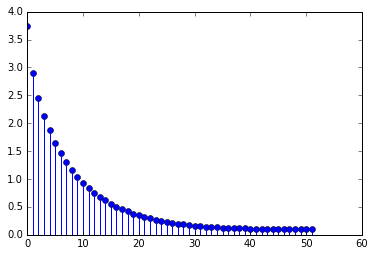

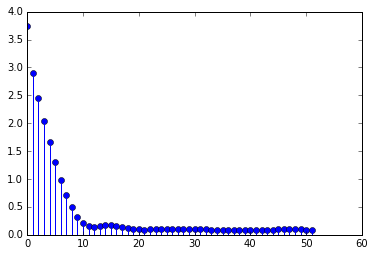

The last ista error measure is:  0.0987335139323
The last fista error measure is:  0.094755720271


In [157]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
L = lip_linreg(A)

x = randn(50)
Z = ista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0, n_iter =50)
Y = fista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0, n_iter =50)

plt.stem(Z[2])
plt.show()
plt.stem(Y[2])
plt.show()
print('The last ista error measure is: ', Z[2][50])
print('The last fista error measure is: ', Y[2][50])

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.70e+00 | 3.26e+00
      10 | 8.24e-01 | 2.16e+00
      20 | 4.61e-01 | 1.44e+00
      30 | 3.39e-01 | 9.79e-01
      40 | 2.91e-01 | 6.88e-01
      50 | 2.72e-01 | 5.12e-01


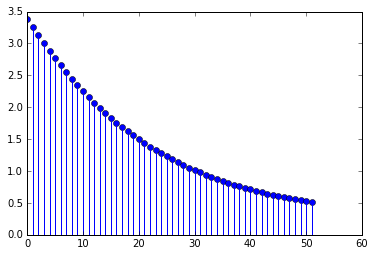

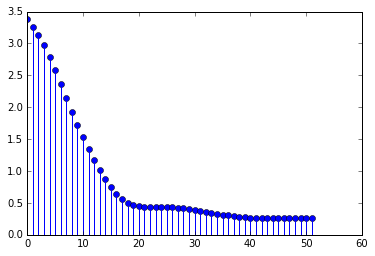

The last ista error measure is:  0.525729037681
The last fista error measure is:  0.263694259109


In [160]:
A, b = simu_logreg(coefs, n_samples=1000, corr=0.5)
L = lip_logreg(A)

x = randn(50)
Z = ista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0, n_iter =50)
Y = fista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0, n_iter =50)

plt.stem(Z[2])
plt.show()
plt.stem(Y[2])
plt.show()
print('The last ista error measure is: ', Z[2][50])
print('The last fista error measure is: ', Y[2][50])

## Algorithms comparison and numerical experiments

In [187]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 40
s = 1e-2

**Questions**

- Compute a precise minimum and a precise minimizer of the linear regression with ridge 
  penalization problem using the parameters give above. This can be done by using fista with 
  1000 iterations.
- Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.

Compute minimum and minimizer

**Questions**

- In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.

- In linear regression and logistic regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.

- In linear regression and logistic regression, compare the performance of the optimization
  algorithms for ridge and lasso penalizations. Explain